# Functions in Julia with more image processing and transformations

> Learning about Julia funtions by implementing a edge detection filter to an image


In this write up
- write function to allow user to input a kron factor, scaling value (and also convex optimisation)
- Downsampling, upsampling,
- Offset index
- More image processing using custom function for edge detection and ImageFiltering's *imfilter*..
- N0f8/16/32/64 data type

In [276]:
begin
    using Images, Colors, ColorVectorSpace, ImageShow, FileIO, ImageIO
    using ImageFiltering
    using OffsetArrays
    using Plots
end

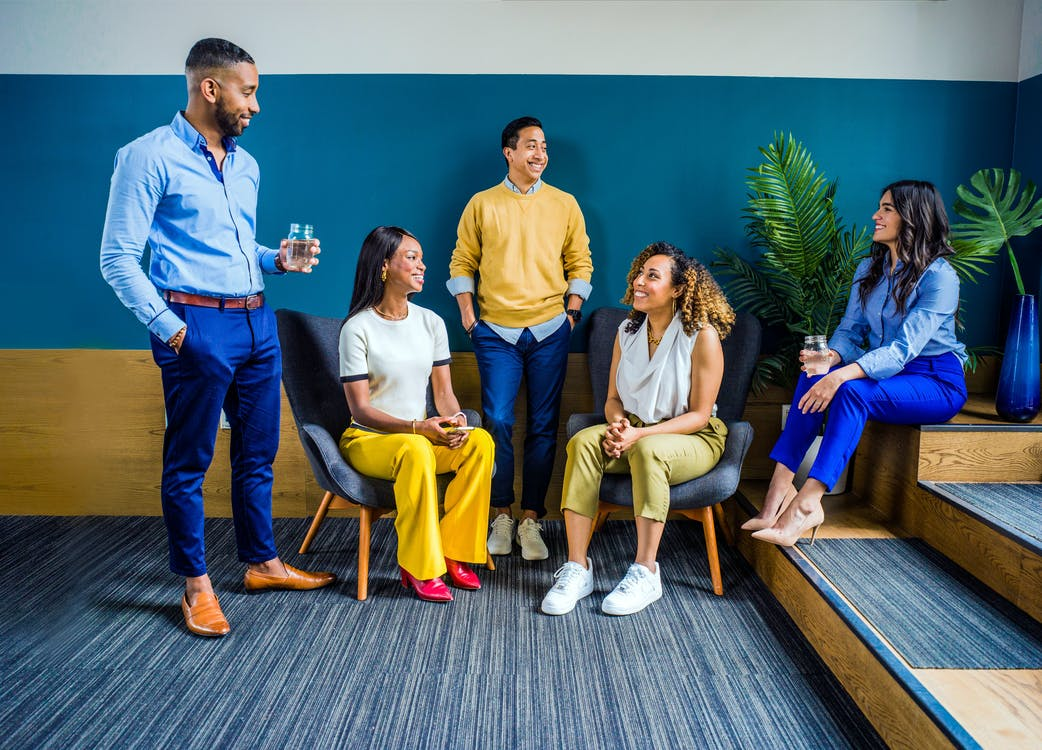

In [277]:
pexels = load("./images/pexels-photo-2422290.jpeg")

In [278]:
size(pexels)

(750, 1042)

Downsampling

By taking only some pixels of the image, we get a lower resolution of the original image (reducing storage size). 

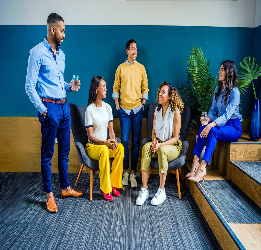

In [283]:
pexels_downsample = pexels[1:3:end, 1:4:end]

In [284]:
size(pexels_downsample)

(250, 261)

The original image which was of size 750x1042 has now been reduced to 250x261 by taking every 3rd pixel of the rows and every 4th pixel of the columns. 

**Upsampling** is the inverse and will just add more pixels to an image. How to upsample is the interesting bit, it is not as simple as just picking which pixel to keep, however there are many ways of upsampling. 

We can upsample an image by multiplying the matrix array by a square matrix using the Kronecke product. A matrix of m*x*n multiplied by a square matrix of p*x*p will result in an (m*x*p)*x*(n*x*p) array which is the upsampled image. 

In Julia, this can be achieved by using the *kron* function, whose arguments are the two arrays, which in our case are the image and a square matrix of 1s. 

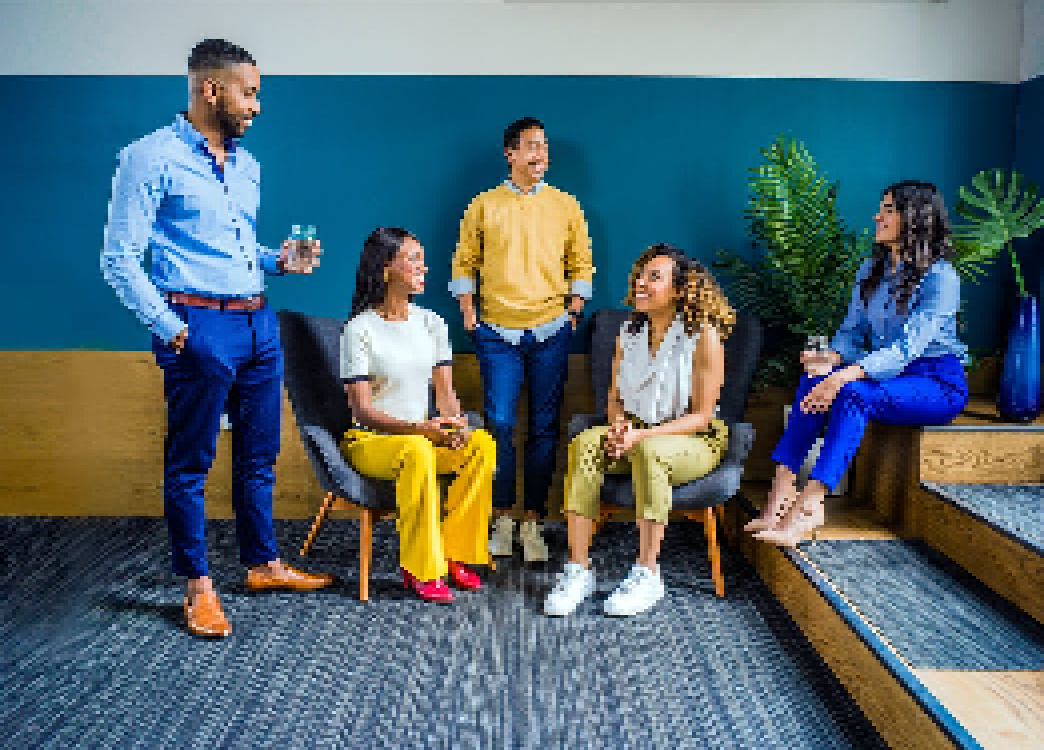

In [285]:
pexels_upsample = kron(pexels_downsample, fill(1, 3, 4))

In [286]:
#use fill to populate an array, matrix with a single specified element
fill(1, 3, 4) 

3×4 Matrix{Int64}:
 1  1  1  1
 1  1  1  1
 1  1  1  1

In [287]:
size(pexels_upsample)

(750, 1044)

### Functions in Julia

3 ways of writing functions:

1. The short form

> &emsp;&emsp;f(a) = a * a

2. The anonymous form

> &emsp;&emsp;x -> sin(x)

3. The block form

> &emsp;&emsp;function func(x, y)<br/>
> &emsp;&emsp;&emsp;x + y, |x - y|

> &emsp;&emsp;end
    
> &emsp;(return is optional)

Writing a function that will pass 2 arguments to a function, *m* and *n* dimensions of a matrix of 1s that will be used to **kron upsample** an image.

Notes:
1. *dim1* is a keyword argument, used as a label (separated from the unlabelled arguments with a semi-colon)
2. *n* will default to *dim1* if only one additional argument to image is specified, creating a square matrix. 

In [300]:
function upsample(image; dim1=m, n=dim1)
    kron(image, fill(1, dim1, n))
end

upsample (generic function with 1 method)

In [301]:
methods(upsample)

# 1 method for generic function "upsample":
[1] upsample(image; dim1, n) in Main at c:\Users\Leonard\Work\Julia\Images_Transformations_Abstractions\images2.ipynb:1

The *methods* function gives more information about a particular function

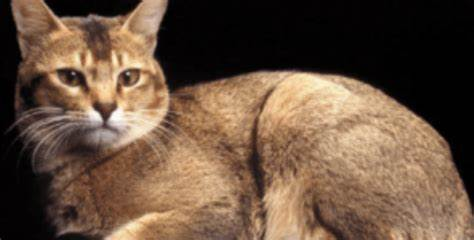

In [291]:
cat = load("./images/cat.jpg")

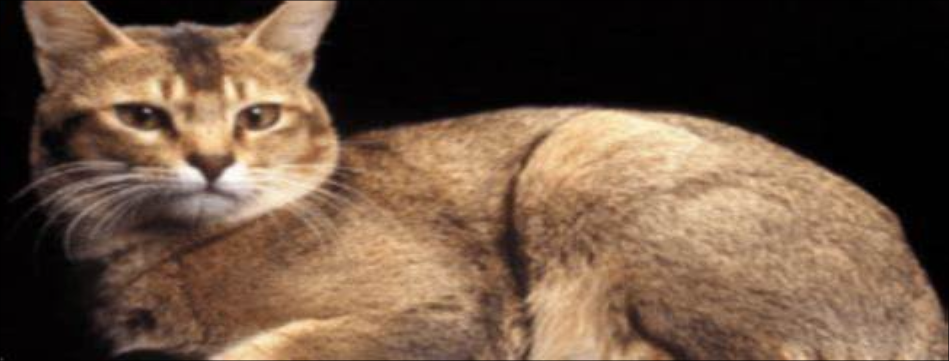

In [302]:
upsample(cat, dim1=3, n=4)

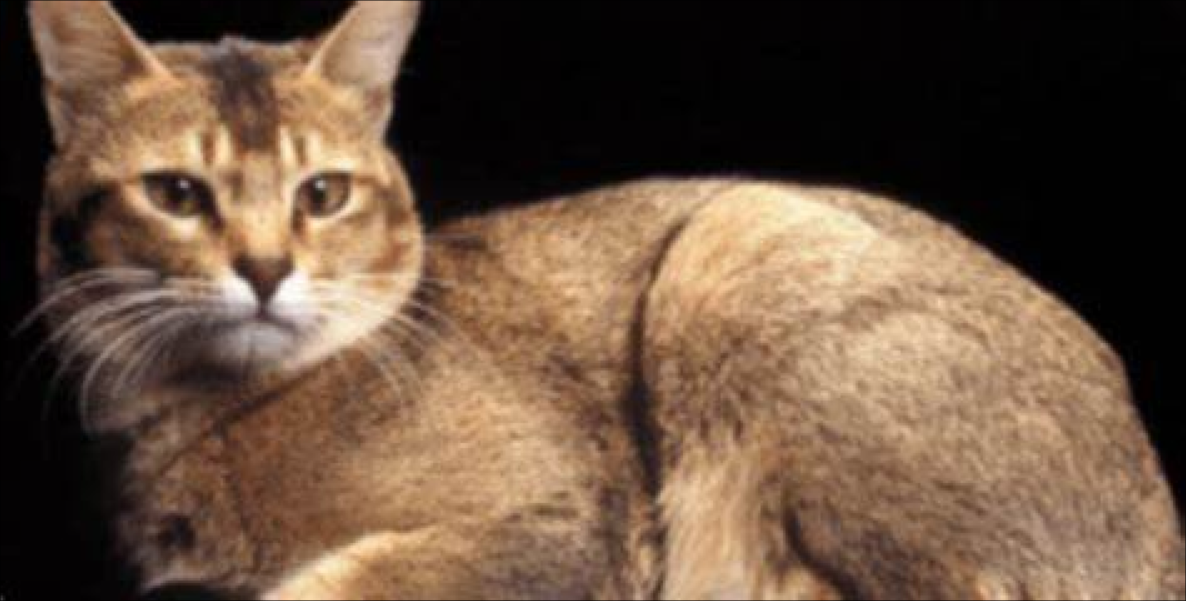

In [303]:
upsample(cat, dim1=5)

### Linear transformations

Scaling is a linear transformation in which a scalar multiplies the image.

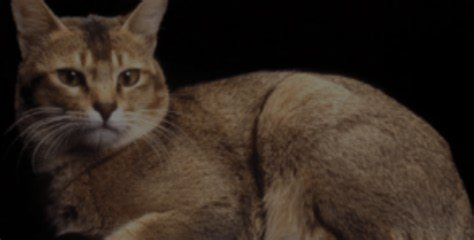

In [304]:
c = 0.5

c .* cat

#the dot is indicating that the scalatr is being broadcast to every pixel of the image

The cat picture has visibly become dull.

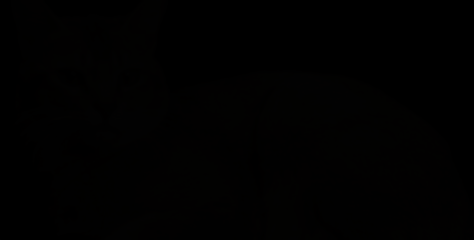

In [305]:
0.01 .* cat

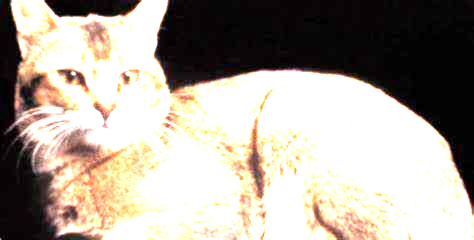

In [306]:
3 .* cat

As c goes to 0, the picture becomes darker, whereas as c goes beyond 1, the picture saturates... 

Combining two or more images, by simply adding the arrays of the images together. 

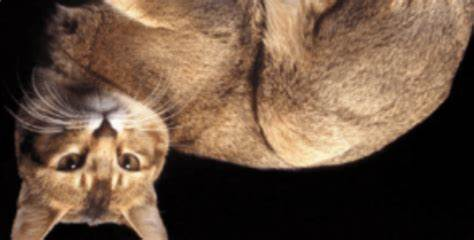

In [85]:
upside_cat = cat[end:-1:1, :]

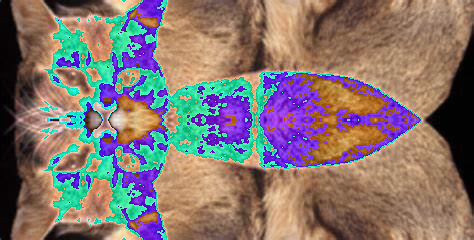

In [86]:
mixed_cat = cat + upside_cat

Convex combination where α and β used to scale the two mixed images add up to 1

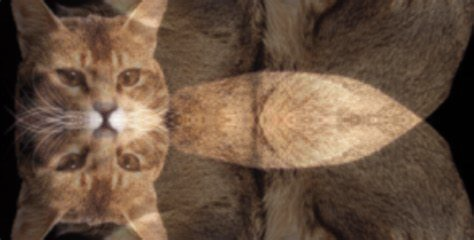

In [87]:
.5 .* cat + .5 .* upside_cat

Write a function that takes α and does a convex transformation of two provided images

In [307]:
function ConvexTransform(image1, image2, α)

    α .* image1 + (1 - α) .* image2

end

ConvexTransform (generic function with 1 method)

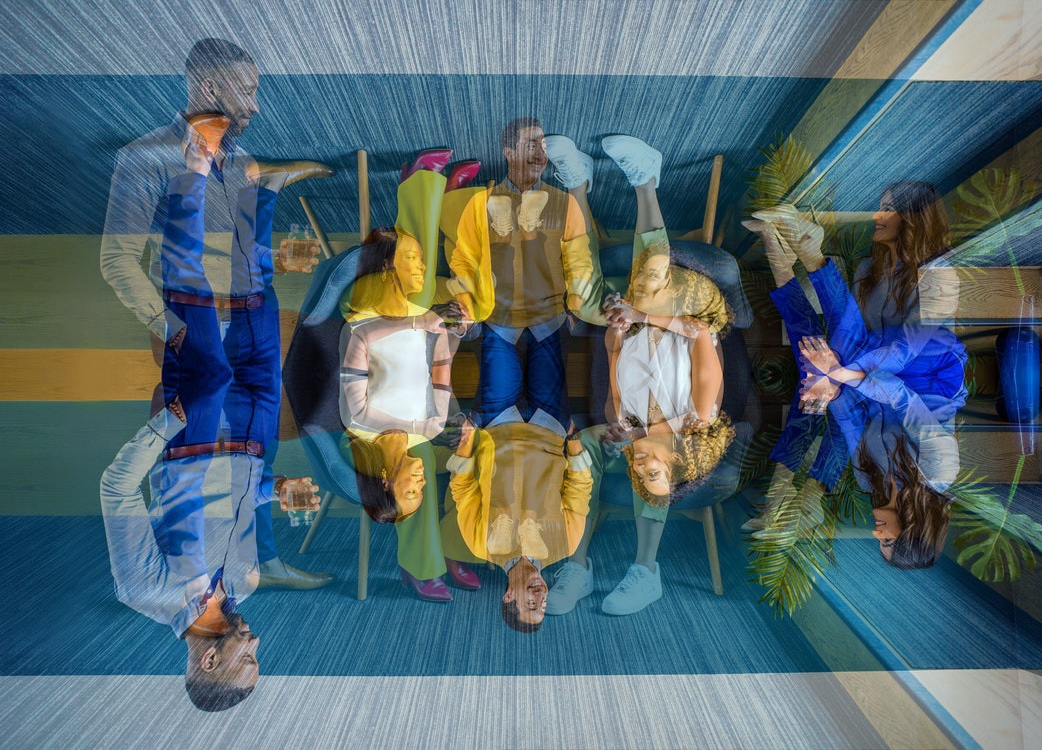

In [308]:
ConvexTransform(pexels, pexels[end:-1:1, :], 0.39)

Many image processing functions use grayscale images, converting to grayscale in Julia...

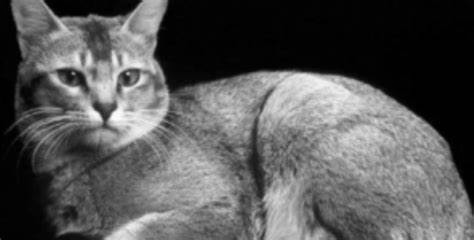

In [157]:
colorview(Gray, Gray.(cat))

#### Edge detection

In [91]:
edge_detect = [0 -1 0; -1 4 -1; 0 -1 0]

3×3 Matrix{Int64}:
  0  -1   0
 -1   4  -1
  0  -1   0

We want to convolve the cat image with the edge detect kernel. Moving the kernel across the pictures, multiplying elementwise and returning the sum, which then becomes the new value of the pixel.

In [256]:
function EdgeDetect(image, filter; padding=0)

    img_gray = channelview(Gray.(image))
    temp = fill(0N0f8, height(img_gray)+2*padding, width(img_gray)+2*padding)
    temp[padding+1:end-padding, padding+1:end-padding] = img_gray

    convolved = fill(0.0, height(img_gray)-height(filter)+1+2*padding, width(img_gray)-width(filter)+1+2*padding)

    for i in 1:1:height(temp)-height(filter)+1
        for j in 1:1:width(temp)-width(filter)+1
            a = sum(temp[i:i+height(filter)-1, j:j+width(filter)-1] .* filter)
            convolved[i, j] = a
        end
    end

    return colorview(Gray, convolved)
    
end

EdgeDetect (generic function with 2 methods)

The function takes as arguments, an image, a filter and a padding value (defaults to 0) and is implemented as follows:
1. Convert the image to grayscale
2. Create temporary array of zeros with added rows and columns to represent padding around the image.
3. To the temporary array, superimpose the gray image, by replacing the 0s with values from the gray image leaving 0s at the outer rows and columns, the padding.
4. Create another temporary array, whose values will be replaced with the new pixel values as the filter moves across the image.
5. Return the filtered image 

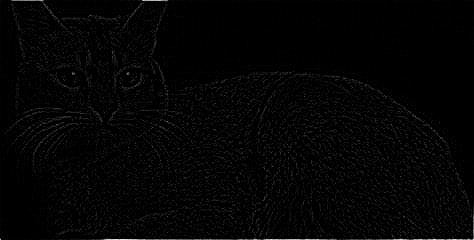

In [258]:
EdgeDetect(cat, edge_detect, padding=1)

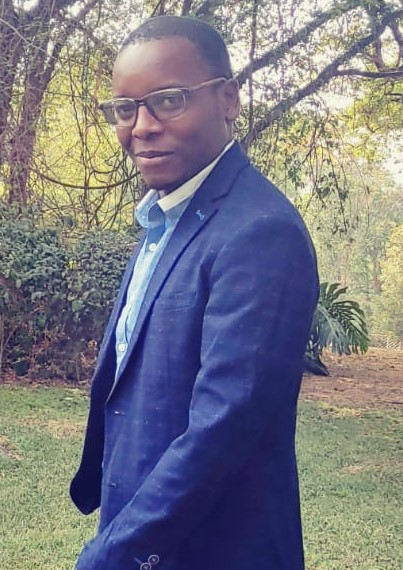

In [174]:
leo = load("./images/leo.jpg")

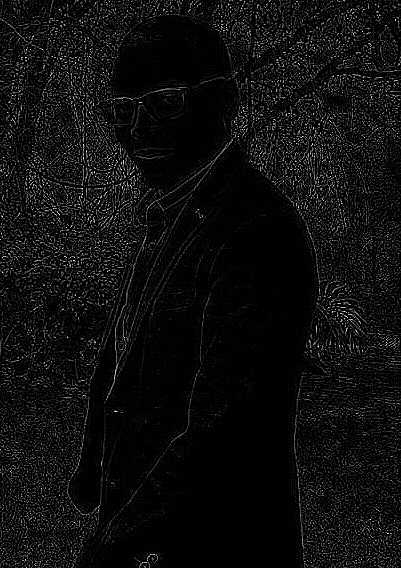

In [177]:
EdgeDetect(leo, edge_detect)

Or you could just use the *imfilter* function from the ImageFiltering package...

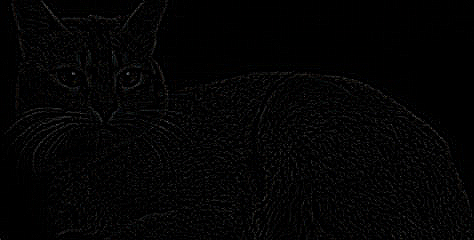

In [153]:
imfilter(cat, edge_detect)

In [262]:
#A function for filtering that doesn't need changing to grayscale first

function FilterImage(image, filter; padding=0)

    img_array = reshape(channelview(image), height(image), width(image), 3)
    temp = fill(0N0f8, height(img_array)+2*padding, width(img_array)+2*padding, 3)
    temp[padding+1:end-padding, padding+1:end-padding, :] = img_array

    convolved = fill(0.0, height(image)-height(filter)+1+2*padding, width(image)-width(filter)+1+2*padding, 3)

    for k in 1:1:3
        for i in 1:1:height(temp)-height(filter)+1
            for j in 1:1:width(temp)-width(filter)+1
                a = sum(temp[i:i+height(filter)-1, j:j+width(filter)-1, k] .* filter)
                convolved[i, j, k] = a
            end
        end
    end

    return colorview(RGB, reshape(convolved, (3, height(convolved), width(convolved))))
    
end

FilterImage (generic function with 2 methods)

Trying out other filters using *imfilter*..

In [185]:
sharpen = [0 -1 0; -1 5 -1; 0 -1 0]

3×3 Matrix{Int64}:
  0  -1   0
 -1   5  -1
  0  -1   0

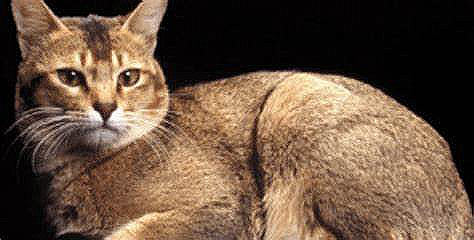

In [233]:
imfilter(cat, sharpen)

Built-in filters..

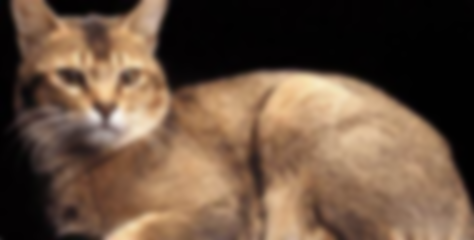

In [267]:
imfilter(cat, Kernel.gaussian(3))

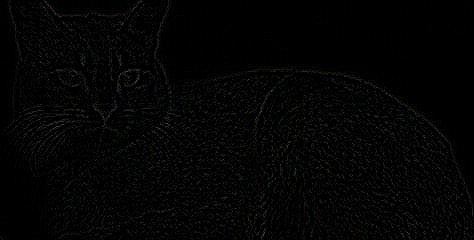

In [268]:
imfilter(cat, Kernel.Laplacian())

Other filters that are available for use with imfilter
    
- sobel
- prewitt
- ando3, ando4, and ando5
- scharr
- bickley
- DoG (Difference-of-Gaussian)
- LoG (Laplacian-of-Gaussian)
- gabor
- moffat

Offsetting

Julia can allows arbitrary indexing (instead of starting at 1 (default) or 0 (Python)). Can be very useful in dealing with arrays,especially multi-dimensional ones.

In [309]:
M = collect(1:10)

OffM = OffsetArray(M, -5:4)

10-element OffsetArray(::Vector{Int64}, -5:4) with eltype Int64 with indices -5:4:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10

In [311]:
println(OffM[-5])
println(OffM[-2])
println(OffM[4])

1
4
10


In [318]:
# Arrays which can be centred automatically, giving the offset indices..

Off = [1 2 2; 3 5 3; 2 6 5]
OffCentered = OffsetArrays.centered(Off)

3×3 OffsetArray(::Matrix{Int64}, -1:1, -1:1) with eltype Int64 with indices -1:1×-1:1:
 1  2  2
 3  5  3
 2  6  5

In [320]:
#and the centre can be found in the original array...

OffsetArrays.center(Off)

(2, 2)

**N0f8/16/...**

When processing images, the array can be stored in this format which is a normalised (between 0 and 1) which makes image processing handy. Can be manipulated to result in floats (like mulitiplication and summing in filters or convolutions)

In [322]:
x = fill(0.0N0f8, 3, 3)

3×3 Array{N0f8,2} with eltype N0f8:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [323]:
x[1, 1]

0.0N0f8

In [325]:
dump(x[1, 1])

N0f8
  i: UInt8 0x00


In [332]:
y = channelview(cat)[1, 6, 3]

0.016N0f8

In [333]:
dump(y)

N0f8
  i: UInt8 0x04


In [335]:
float(y)

0.015686275f0